### plot plant physiology impact 


In [157]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os 
from glob import glob
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns

## Understanding $Aphys_{norm}$

There are two specific CMIP5 experiments that were used to estimate the impact of plant physiology on different environmental variables. In one experiment only plants saw increases in CO$_2$ mixing ratios and a full experiment where plants and radiative budgets saw CO2. The change in a variable for these experiments are $\delta_{Phys}$ and $\delta_{Rad}$ respectively. $\delta_{Phys}$ or $\delta_{Rad}$ is the difference between the average of 20 years at high CO$_2$ minus 20 years at low CO$_2$. 

The importance of plant phsyiology can then be estimated using the following equation (assuming they are linearly additive). 

$$Aphys_{norm} = \frac{\delta_{Phys}}{\delta_{Rad}+\delta_{Phys}}$$

Values can come in above 1 or below zero, but Abby thinks of it as the fraction explained, where outside [0 1] is explaining too much or the experiments disagree on the sign of the change. Below, I will demonstate what different values of $Aphys_{norm}$ mean in the context of some made up values. Then I will sort the variables as those most impacted by plant physiology to those least impacted. 

In [463]:
def calc_aphys_norm(delta_Phys, delta_Rad) : 
    return delta_Phys / (delta_Rad+delta_Phys)

In [500]:
delta_Phys = np.linspace(-100,100,1000)
delta_Rad  = -2.3
Aphys_norm = calc_aphys_norm(delta_Phys, delta_Rad)

In [501]:
print(calc_aphys_norm(delta_Phys=1, delta_Rad=0))
print(calc_aphys_norm(delta_Phys=1, delta_Rad=1))
print(calc_aphys_norm(delta_Phys=-1.1, delta_Rad=1))
print(calc_aphys_norm(delta_Phys=1.1, delta_Rad=-1.3))
print(calc_aphys_norm(delta_Phys=10000, delta_Rad=-10000.0000001))
print(calc_aphys_norm(delta_Phys=1.1, delta_Rad=-1))

1.0
0.5
10.999999999999991
-5.500000000000002
-99999238556.461
10.999999999999991


**NOTE:** Aphys_norm blows up to massive **negative** number when the change (big or small) is very similar in magnitude but apposite sign for both.

**NOTE:** Aphys_norm blows up to massive **positive** number when the change (big or small) is very similar in magnitude but apposite sign for both.

In [502]:
print(delta_Rad)

-2.3


# TODO": add background shading to describe what happens here. 

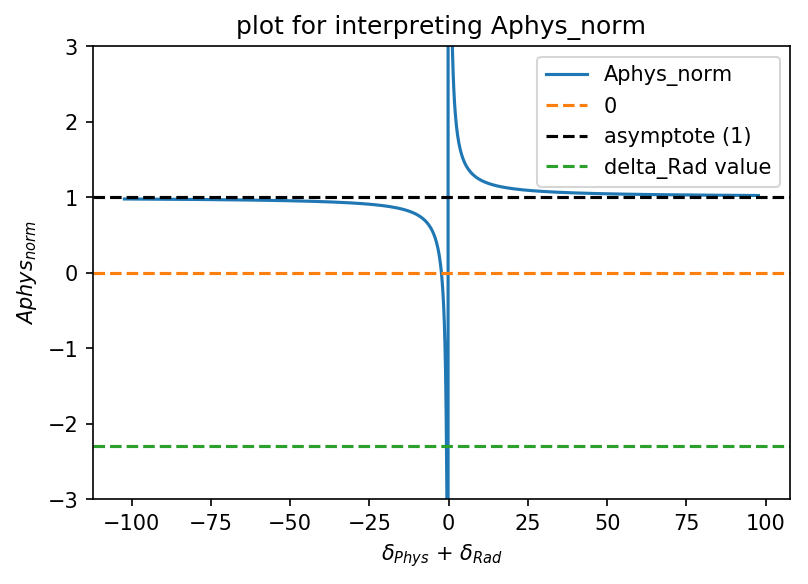

In [503]:
plt.figure(dpi=150)
plt.plot(delta_Phys+delta_Rad, Aphys_norm,"-", label="Aphys_norm")
plt.xlabel("$\delta_{Phys}$ + $\delta_{Rad}$")
plt.ylabel("$Aphys_{norm}$")
plt.axhline(0, c="C1", linestyle="--", label="0")
plt.axhline(1, c="k", linestyle="--", label="asymptote (1)")
plt.axhline(delta_Rad, c="C2", linestyle="--", label="delta_Rad value")
#plt.axvline(0, c="C3", linestyle="--", label="delta_Phys=0")
plt.title("plot for interpreting Aphys_norm")
plt.ylim( (-3,3) )
plt.legend()
plt.show()

#### Setup plotting over the US

I have regridded the physiology difference experiments so that I can apply the common masks for western US and baileys ecoregions if nessisary. 

In [44]:
# Load western US ecoregions masks file
f = os.path.join("..","Data","LandCover", "common_grid_land_mask.nc")
nc = Dataset(f,"r")
land_mask = nc.variables["land_mask"][:]
grid_lat = nc.variables["lat"][:]
grid_lon = nc.variables["lon"][:]
nc.close()

X, Y = np.meshgrid(grid_lon, grid_lat)

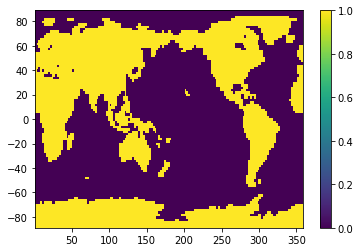

In [45]:
plt.pcolormesh(X,Y,land_mask)
plt.colorbar()
plt.show()

In [60]:
type(X)

numpy.ma.core.MaskedArray

In [64]:
X.data[western_US > 1].max()

258.75

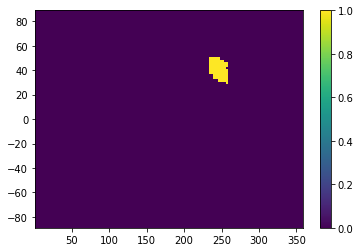

In [74]:
f = os.path.join("..","Data","LandCover", "bailys_division_masks_common_grid.nc")
nc = Dataset(f,"r")
# Western US comes in at the number of times a grid overlaps 
# any baileys division in the west, turn count into binary. 
western_US = nc.variables["western_US"][:]
grid_lat = nc.variables["lat"][:]
grid_lon = nc.variables["lon"][:]
nc.close()

# Do not want this western US mask to go to far east. 
western_US_mask = np.array( (western_US > 0) & (X < 257) , dtype=int)

plt.pcolor(X,Y, western_US_mask)
plt.colorbar()
plt.show()

#### Plotting western US using cartopy 

In [76]:
proj = ccrs.NearsidePerspective(central_longitude=255., central_latitude=35.,satellite_height=10785831)

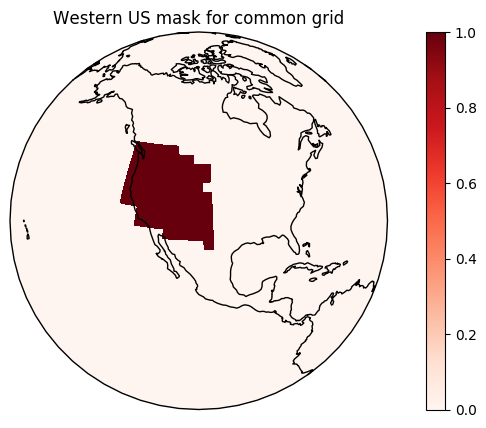

In [81]:
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection=proj)

colors = ax.pcolormesh(X,Y, western_US_mask, transform=ccrs.PlateCarree(), cmap="Reds")

ax.coastlines()
ax.set_global()
fig.colorbar(colors)
plt.title("Western US mask for common grid")

plt.show()

Directory with all of the Aphys estimates for different variables and different models

In [396]:
data_dir = os.path.join("..","Data", "rad_phys","rad_phys_split_common_grid","")
data_dir

'../Data/rad_phys/rad_phys_split_common_grid/'

In [405]:
files = glob(data_dir+"*.nc")
files_clean = []
variables = [] # get the variables available in the directory 
for f in files :
    files_clean.append( f.replace(data_dir,"") )

In [406]:
files_clean[0]

'Aphys_norm_bcc-csm1-1_hfls.nc'

In [407]:
df = pd.DataFrame(np.nan, columns = ["aphys_mean", "feature", "season", "model"], index=files_clean)
df.head()

,aphys_mean,feature,season,model
Aphys_norm_bcc-csm1-1_hfls.nc,NaN,NaN,NaN,NaN
Aphys_norm_bcc-csm1-1_hfls_annual.nc,NaN,NaN,NaN,NaN
Aphys_norm_bcc-csm1-1_hfls_spring.nc,NaN,NaN,NaN,NaN
Aphys_norm_bcc-csm1-1_hfls_summer.nc,NaN,NaN,NaN,NaN
Aphys_norm_bcc-csm1-1_hfls_winter.nc,NaN,NaN,NaN,NaN


In [408]:
f = files_clean[0]
f

'Aphys_norm_bcc-csm1-1_hfls.nc'

In [409]:
for f in files_clean : 
    
    # determine what season is associated with the season
    if f.find("summer") != -1 :
        season = "summer"
    elif f.find("winter") != -1 :
        season = "winter"
    elif f.find("spring") != -1 : 
        season = "spring"
    else :
        season = "none"
    
    if season != "none" : 
        
        # Store the season
        df.loc[f, "season"] = season 
        
        # Load the nc data for this file 
        nc_file = os.path.join(data_dir, f)
        nc = Dataset(nc_file, "r")
        variable = list(nc.variables.keys())[-1]
        variable_values = nc.variables[variable][:].data
        nc.close()
        
        # Replace grid values that are higher than 1 or less than 0
        variable_values[variable_values > 1. ] = 1
        variable_values[variable_values < 0. ] = 0
        
        # Store var name
        df.loc[f, "feature"] = variable 
        
        # Get the western US mean
        variable_masked = np.ma.masked_where(western_US_mask==0, variable_values)
        df.loc[f, "aphys_mean"] = np.ma.mean(variable_masked)
        
        # Get the model name, no order, so remove all other descriptors and see 
        # what remains
        m=f.replace(variable,"").replace(season,"").replace("Aphys_norm","").replace("_","").replace(".nc","")
        df.loc[f, "model"] = m
        
    else :
        # And if the value was not a seasonal estimate, get rid of that row 
        df.drop(labels=f, inplace=True)


In [410]:
df.head()

,aphys_mean,feature,season,model
Aphys_norm_bcc-csm1-1_hfls_spring.nc,0.155350,hfls,spring,bcc-csm1-1
Aphys_norm_bcc-csm1-1_hfls_summer.nc,0.383211,hfls,summer,bcc-csm1-1
Aphys_norm_bcc-csm1-1_hfls_winter.nc,0.140120,hfls,winter,bcc-csm1-1
Aphys_norm_bcc-csm1-1_hurs_spring.nc,0.370359,hurs,spring,bcc-csm1-1
Aphys_norm_bcc-csm1-1_hurs_summer.nc,0.302128,hurs,summer,bcc-csm1-1


In [411]:
# Set values greater than 1 to 1 and values less than -1 to 0
#set_to_1 = df.aphys_mean.values > 1. 
#set_to_0 = df.aphys_mean.values < 0.

df_limited = df.copy()

#df_limited.loc[set_to_1,"aphys_mean"] = 1.
#df_limited.loc[set_to_0,"aphys_mean"] = 0.0 

In [412]:
print("max of aphys:", df_limited.aphys_mean.max())
print("min of aphys:", df_limited.aphys_mean.min())

max of aphys: 0.6684491208673725
min of aphys: 0.018912927275206142


Text(0, 0.5, 'number of models and variables')

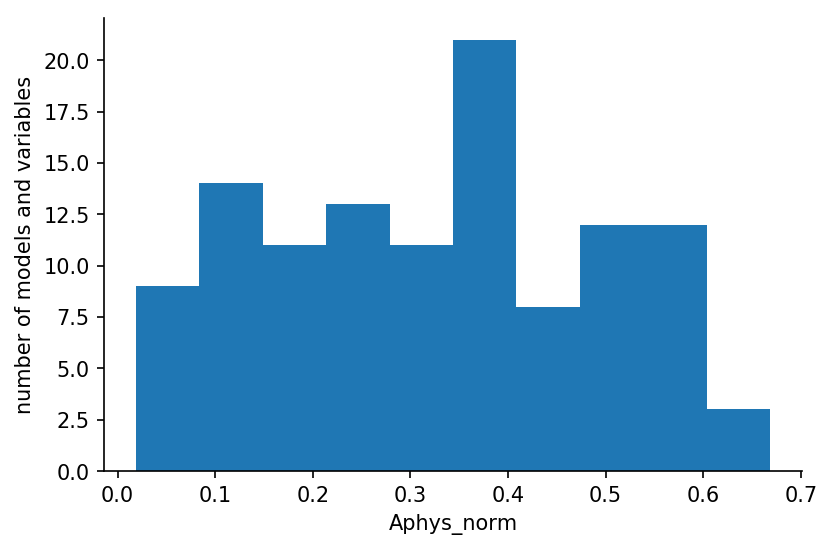

In [413]:
plt.figure(dpi=150)
ax = plt.subplot(111)
_ = plt.hist(df_limited.aphys_mean.values)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Aphys_norm")
plt.ylabel("number of models and variables")

### Start visualizing the data to see if a natural break exists

<Figure size 1200x800 with 0 Axes>

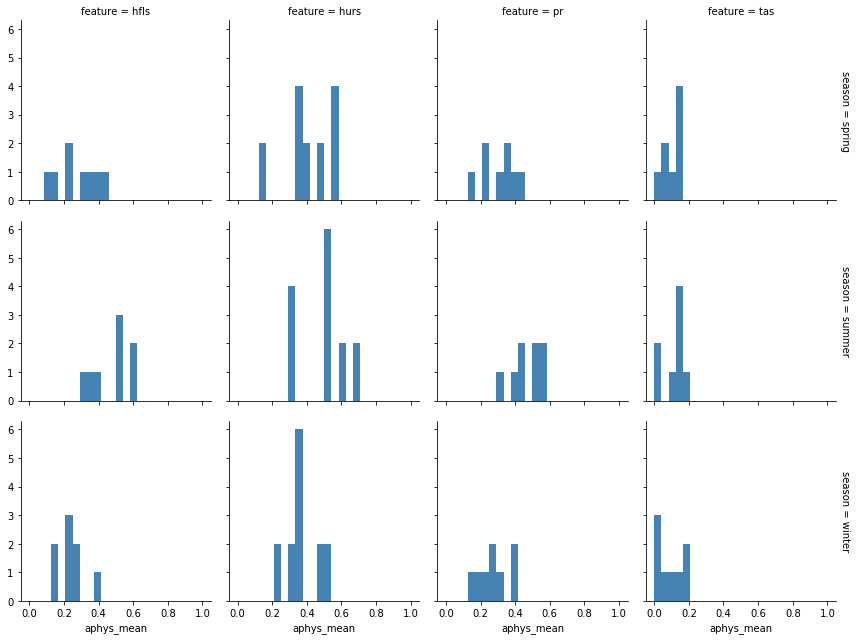

In [414]:
plt.figure(dpi=200)
#plt.subplot(1, 1, 1)
g = sns.FacetGrid(df_limited, row="season", col="feature", margin_titles=True)
g.map(plt.hist, "aphys_mean", color="steelblue", bins= middle_bins)
plt.show()

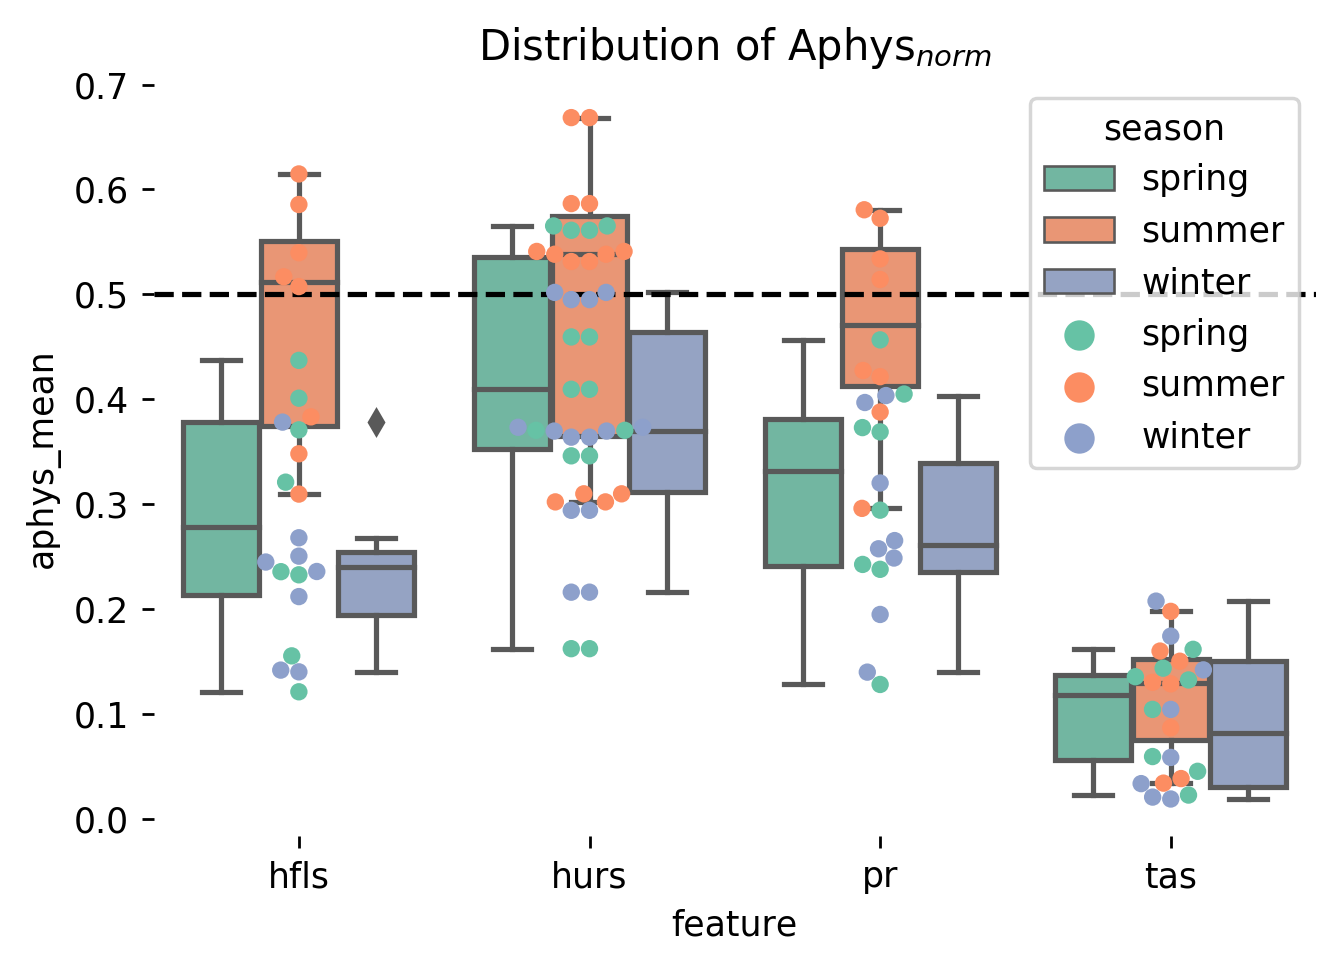

In [433]:
plt.figure(dpi=250)
ax = sns.boxplot(x="feature", y="aphys_mean", hue="season", data=df_limited, palette="Set2")
ax = sns.swarmplot(x="feature", y="aphys_mean", hue="season", data=df_limited, palette="Set2")
plt.title("Distribution of Aphys$_{norm}$")
plt.axhline(0.5, c="k", linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.show()

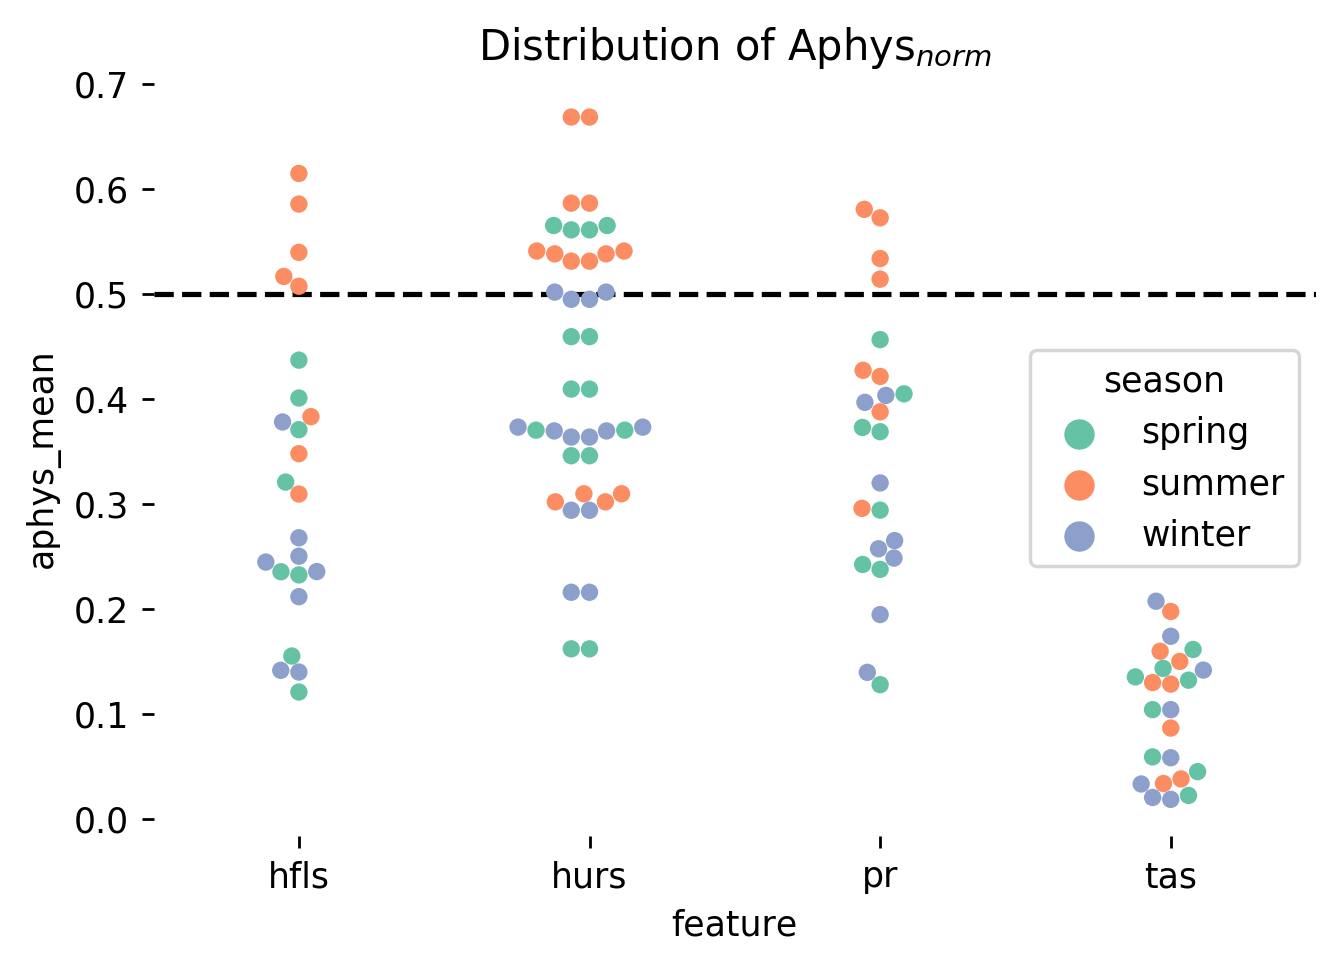

In [504]:
plt.figure(dpi=250)
#ax = sns.boxplot(x="feature", y="aphys_mean", hue="season", data=df_limited, palette="Set2")
ax = sns.swarmplot(x="feature", y="aphys_mean", hue="season", data=df_limited, palette="Set2")
plt.title("Distribution of Aphys$_{norm}$")
plt.axhline(0.5, c="k", linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.show()

### Preliminary analysis
- Temperature is the only variable where we do not have to 'set' the values that go outside the range of 0 to 1. That means it is the only variable where there are no differences in sign between the two runs. 
- Previously I had set pr as an "atmospheric centric" variable. Not a lot of justification for that in this figure. 
- The next plot will show the same thing but without the features breing broken down by season. 

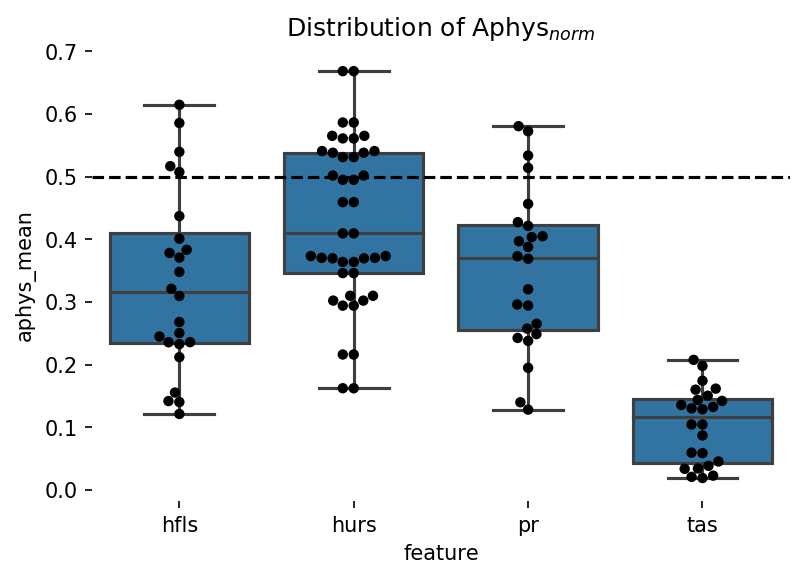

In [435]:
plt.figure(dpi=150)
ax = sns.boxplot(x="feature", y="aphys_mean", data=df_limited, color="C0")
ax = sns.swarmplot(x="feature", y="aphys_mean", data=df_limited, color="k")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title("Distribution of Aphys$_{norm}$")
plt.axhline(0.5, c="k", linestyle="--")
plt.show()

In [426]:
df_means = df_limited.groupby(["feature","season"]).mean().copy()
df_means

aphys_mean
feature season            
hfls    spring    0.284309
        summer    0.475605
        winter    0.233856
hurs    spring    0.410523
        summer    0.496743
        winter    0.373380
pr      spring    0.313257
        summer    0.466696
        winter    0.278307
tas     spring    0.100596
        summer    0.115742
        winter    0.094973

In [427]:
df_means.loc[("pr","summer"),:]

aphys_mean    0.466696
Name: (pr, summer), dtype: float64

In [428]:
df_means.loc[(slice(None), "summer" ), :]

,,aphys_mean
feature,season,
hfls,summer,0.475605
hurs,summer,0.496743
pr,summer,0.466696
tas,summer,0.115742


### If no obvious split in the data exists
- Sort the features from least influenced to most. 
- Split them in half, make division that way. Assume that VPD goes into the same category as temperature since it increases exponetially with temperature and not water vapor, i.e., more strongly influenced by temperature than moisture. 

In [429]:
feature_means = df_limited.groupby(["feature"]).mean().copy()
order = np.argsort(feature_means.aphys_mean.values)
feature_means=feature_means.iloc[order,:].copy()
feature_means["feature"] = feature_means.index.values
feature_means

,aphys_mean,feature
feature,,
tas,0.103770,tas
hfls,0.331256,hfls
pr,0.352753,pr
hurs,0.426882,hurs


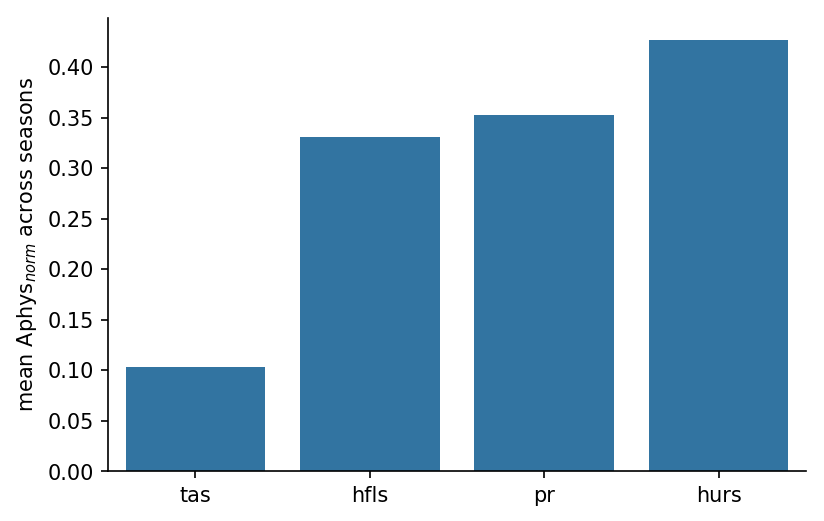

In [437]:
plt.figure(dpi=150)
ax = sns.barplot(x="feature", y="aphys_mean", data=feature_means, color="C0")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("")
plt.ylabel("mean Aphys$_{norm}$ across seasons")
#plt.title("variables ranked by plant physiology influence")
plt.show()